In [1]:
RANDOM_STATE = 44
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Ensure the notebook runs from project root so relative paths like 'data/creditcard.csv' work
import os
from pathlib import Path
print("Working directory before change:", os.getcwd())
project_root = Path(r'C:\Users\nolan\OneDrive\Desktop\School\CS\Supervised-Learning-Final-Project')
if project_root.exists():
    os.chdir(project_root)
    print("Changed working directory to:", os.getcwd())
else:
    raise FileNotFoundError(f"Project root not found: {project_root}")
# Show top-level contents to confirm working directory
print('Top-level files/folders:', os.listdir('.'))

Working directory before change: c:\Users\nolan\OneDrive\Desktop\School\CS\Credit-Card-Fraud-Detection\notebooks
Changed working directory to: c:\Users\nolan\OneDrive\Desktop\School\CS\Credit-Card-Fraud-Detection
Top-level files/folders: ['.git', 'data', 'figures', 'notebooks', 'requirements.txt']


In [3]:
# Create figures directory if it doesn't exist
figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)
print(f"Figures will be saved to: {figures_dir.absolute()}")

Figures will be saved to: c:\Users\nolan\OneDrive\Desktop\School\CS\Credit-Card-Fraud-Detection\figures


In [4]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

In [7]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority' ,random_state=RANDOM_STATE)
smote_x_train, smote_y_train = smote.fit_resample(x_train, y_train)
# Don't apply to test set to avoid data leakage

   Class  Original   SMOTE
0      0    227451  227451
1      1       394  227451


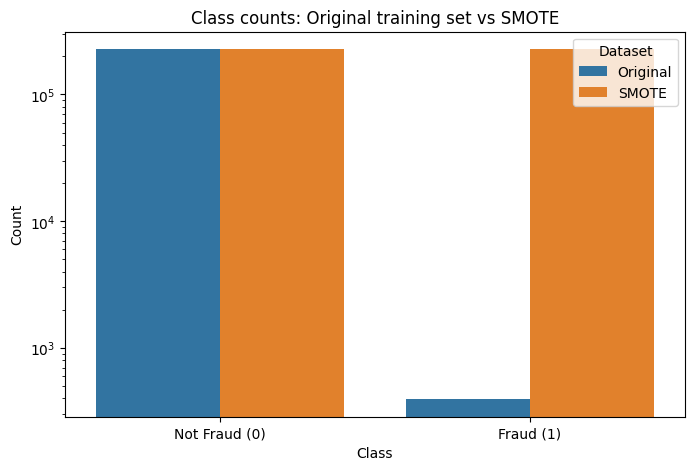

Saved: smote_class_comparison.png


In [8]:
# Compare class distributions: original vs SMOTE (fixed melt / index handling)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure smote_x_train is a DataFrame and smote_y_train is a Series for easy plotting
if not isinstance(smote_x_train, pd.DataFrame):
    smote_x_train = pd.DataFrame(smote_x_train, columns=x_train.columns)
if not isinstance(smote_y_train, pd.Series):
    smote_y_train = pd.Series(smote_y_train, name='Class')

# Create a small summary DataFrame for easy plotting, ensuring both class labels are present
classes = [0, 1]
orig_counts = y_train.value_counts().reindex(classes, fill_value=0).sort_index()
smote_counts = smote_y_train.value_counts().reindex(classes, fill_value=0).sort_index()

counts_df = pd.DataFrame({'Class': classes, 'Original': orig_counts.values, 'SMOTE': smote_counts.values})
# Optional print for debugging — shows that we have both classes in the DataFrame
print(counts_df)

counts_melt = counts_df.melt(id_vars='Class', var_name='Dataset', value_name='Count')

plt.figure(figsize=(8,5))
sns.barplot(data=counts_melt, x='Class', y='Count', hue='Dataset')
plt.yscale('log')
plt.title('Class counts: Original training set vs SMOTE')
plt.xticks([0,1], ['Not Fraud (0)', 'Fraud (1)'])
plt.savefig(figures_dir / 'smote_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: smote_class_comparison.png")

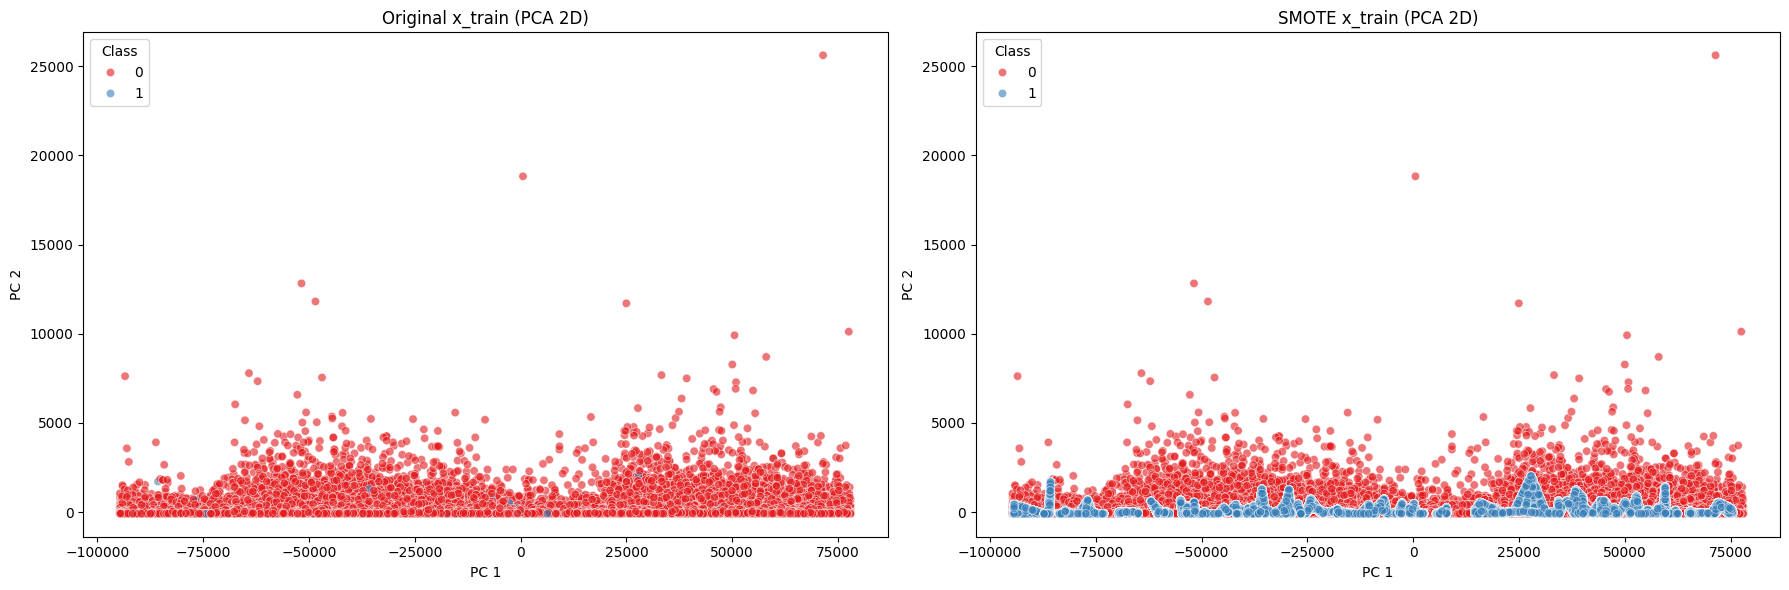

Saved: smote_pca_visualization.png


In [9]:
# PCA visualization of original vs SMOTE datasets (2D projection)
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA on the original x_train so both datasets are projected to the same space
pca = PCA(n_components=2, random_state=44)
pca.fit(x_train)

orig_2d = pca.transform(x_train)
smote_2d = pca.transform(smote_x_train)
# Ensure smote_y_train is a Series for plotting
if not isinstance(smote_y_train, pd.Series):
    smote_y_train = pd.Series(smote_y_train, name='Class')

fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.scatterplot(x=orig_2d[:,0], y=orig_2d[:,1], hue=y_train, palette='Set1', alpha=0.6, ax=axes[0], legend='brief')
axes[0].set_title('Original x_train (PCA 2D)')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
sns.scatterplot(x=smote_2d[:,0], y=smote_2d[:,1], hue=smote_y_train, palette='Set1', alpha=0.6, ax=axes[1], legend='brief')
axes[1].set_title('SMOTE x_train (PCA 2D)')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
plt.tight_layout()
plt.savefig(figures_dir / 'smote_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: smote_pca_visualization.png")

C:\Users\nolan\AppData\Local\Temp\ipykernel_6828\1578581864.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=orig_df, x='Class', y=feature, ax=axes[0], palette='Set2')
C:\Users\nolan\AppData\Local\Temp\ipykernel_6828\1578581864.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=smote_df, x='Class', y=feature, ax=axes[1], palette='Set2')
C:\Users\nolan\AppData\Local\Temp\ipykernel_6828\1578581864.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=smote_df, x='Class', y=feature, ax=axes[1], palette='Set2')


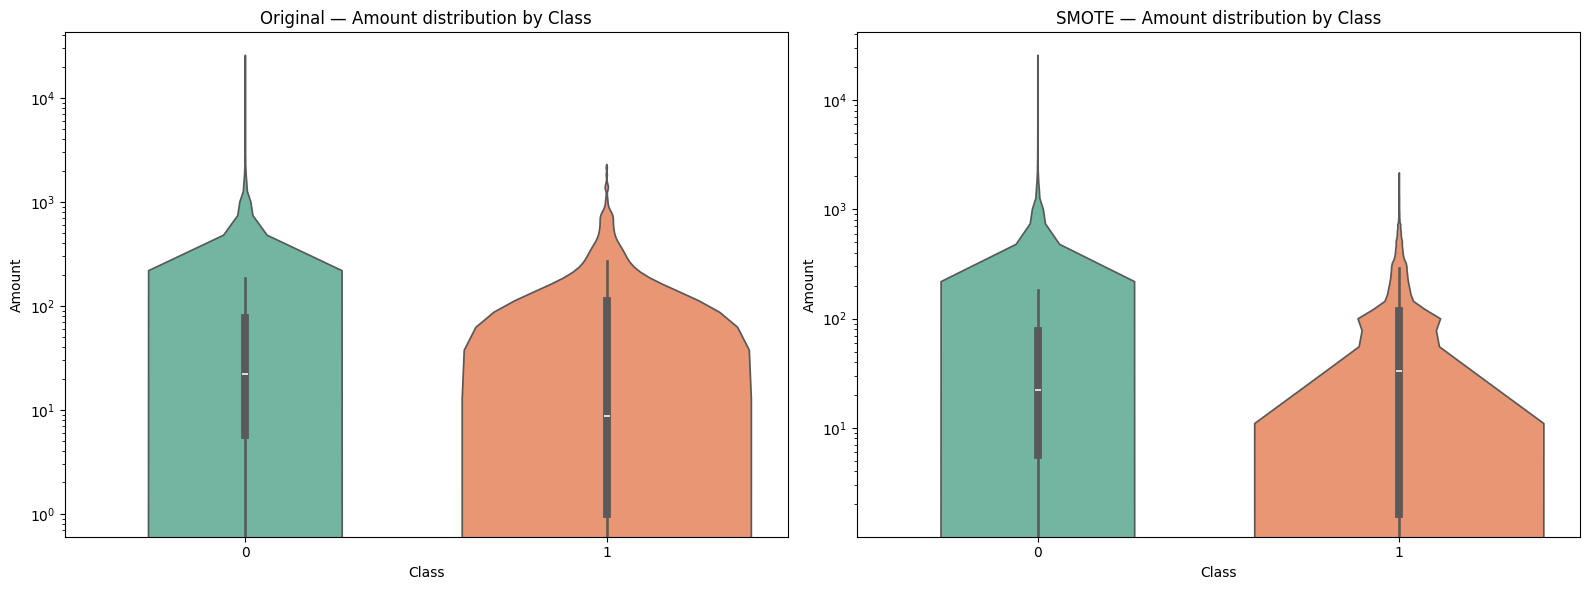

Saved: smote_amount_distribution.png


In [10]:
# Compare 'Amount' distribution by class for original vs SMOTE
feature = 'Amount'  # change to another column name if you prefer
orig_df = x_train.copy()
orig_df['Class'] = y_train.values
smote_df = smote_x_train.copy()
smote_df['Class'] = smote_y_train.values if hasattr(smote_y_train, 'values') else smote_y_train

# Use violinplots to compare distribution by class
fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.violinplot(data=orig_df, x='Class', y=feature, ax=axes[0], palette='Set2')
axes[0].set_title('Original — Amount distribution by Class')
axes[0].set_yscale('log')
sns.violinplot(data=smote_df, x='Class', y=feature, ax=axes[1], palette='Set2')
axes[1].set_title('SMOTE — Amount distribution by Class')
axes[1].set_yscale('log')
plt.tight_layout()
plt.savefig(figures_dir / 'smote_amount_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: smote_amount_distribution.png")

In [11]:
x_train.to_csv('data/preprocessed/x_train.csv', index=False)
y_train.to_csv('data/preprocessed/y_train.csv', index=False)

smote_x_train.to_csv('data/preprocessed/x_train_smote.csv', index=False)
smote_y_train.to_csv('data/preprocessed/y_train_smote.csv', index=False)

x_test.to_csv('data/preprocessed/x_test.csv', index=False)
y_test.to_csv('data/preprocessed/y_test.csv', index=False)